In [105]:
import sys
import scipy as sc
from lmfit import Minimizer, minimize,Parameters, report_fit
from numpy import exp, log
import numpy as np
import pandas as pd
import matplotlib.pylab as plt
from model_comparison import get_AIC, get_BIC
from model_residuals import *
from model_visualisation import *
from model_fittings import *

In [106]:
k = 8.617e-5
d = pd.DataFrame(pd.read_csv("../Data/ThermRespData.csv"))
d = d[d['OriginalTraitValue'] > 0]
d['LoggedOriginalTraitValue'] = np.log(d['OriginalTraitValue'])
d = d[["ID", "ConTemp", "OriginalTraitValue",
        "LoggedOriginalTraitValue", "OrignalTraitName",  "OriginalTraitUnit"]]
d["ConTemp_Kelvin"] = d["ConTemp"] + 273.15
d["Transferred_ConTemp"] = 1/k*d['ConTemp_Kelvin']+1/283.15*k
d["Transferred_kT"] = 1/k*d["ConTemp_Kelvin"]

# plt.plot(sub["Transferred_kT"], sub["LoggedOriginalTraitValue"], "r.")

In [107]:
id = 2
sub = d[d["ID"] == id]
Schoolfield_model, p_sch, _, _ = Schoolfield_model(id, d, min_round=200, max_round=220, only_return_info=False) 

In [108]:
Schoolfield_model

,id,B0,E,Th,Eh,chisqr,RSS,TSS,Rsq,aic,bic,aicc,RSS_log,TSS_log,Rsq_log,aic_log,bic_log,aicc_log
0,2,8.341986,0.232997,306.461404,1.775613,0.013243,0.801365,42.872523,0.981308,15.035,13.472752,NaN,0.013243,0.879421,0.984941,-7.04157,-5.479322,NaN


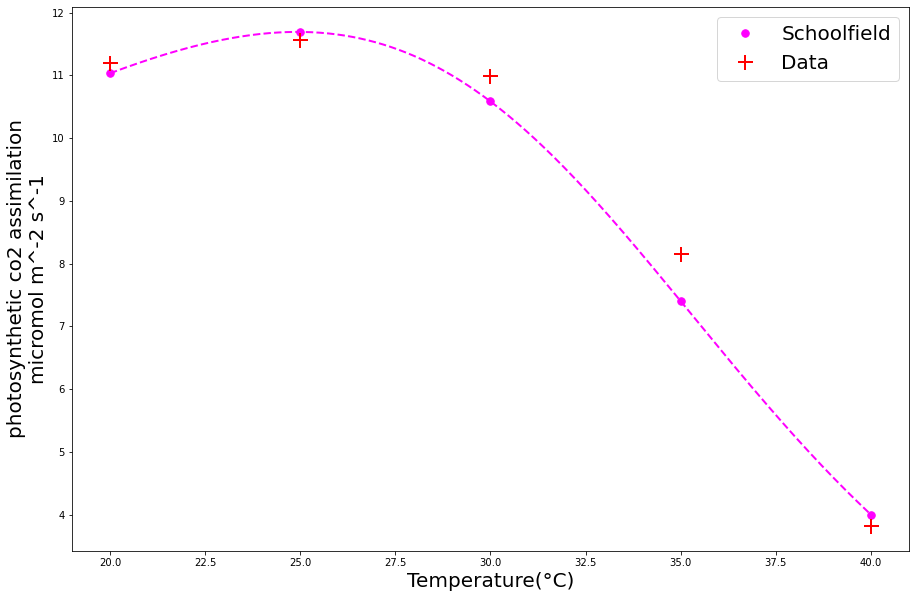

In [109]:

T = np.asarray(sub["ConTemp"])  # Temperature in kelvin
T_kelvin = np.asarray(sub["ConTemp_Kelvin"])
# Unlogged Trait value
B = np.asarray(sub["OriginalTraitValue"])
B_name = sub["OrignalTraitName"].iloc[0]
B_unit = sub["OriginalTraitUnit"].iloc[0]

plt.rcParams['figure.figsize'] = [15, 10]
result_model = B + residuals_school_original(p_sch, T_kelvin, B)
plt.plot(T, result_model, '.', markerfacecolor="magenta", 
markeredgecolor="magenta", markersize=15, label="Schoolfield")
# Get a smooth curve by plugging a time vector to the fitted non-linear model
t_vec = np.linspace(min(T_kelvin), max(T_kelvin), 2000)
N_vec = np.ones(len(t_vec))
residual_smooth = residuals_school_original(p_sch, t_vec, N_vec)
plt.plot(t_vec - 273.15, residual_smooth + N_vec, "magenta", linestyle='--', linewidth=2)

# Plot data points
plt.plot(T, B, 'r+', markersize=15,
markeredgewidth=2, label='Data')

# Plot legend
plt.legend(fontsize=20)
plt.xlabel('Temperature(°C)', fontsize=20)
plt.ylabel('%s\n%s' % (B_name, B_unit), fontsize=20)
plt.ticklabel_format(style='scientific', scilimits=[0, 3])

In [104]:
Arrhenius_after = pd.DataFrame(data = None)
Arrhenius_before = pd.DataFrame(data = None)
quadratic = pd.DataFrame(data = None)
cubic = pd.DataFrame(data = None)
Briere = pd.DataFrame(data=None)
Schoolfield = pd.DataFrame(data=None)
for id in range(0, 6):
    if len(d[d["ID"] == id]) > 4: 
        print("Fitting Linear Modle of ID %d" % id)
        quad_info, cubic_info, fit_quad, fit_cubic = linear_models(id, d, only_return_info=False)
        quadratic = quadratic.append(quad_info)
        cubic = cubic.append(cubic_info)
        
        print("Fitting Briere Modle of ID %d" % id)
        briere_info, p_bri = Briere_model(
            id, d, min_round=140, max_round=180, only_return_info=False)
        # Briere = Briere.append(briere_info)
        
        print("Fitting Simplified Schoolfield Modle of ID %d" % id)
        school_info, p_sch, arr_before, arr_after = Schoolfield_model(
            id, d, min_round=1000, max_round=1200, only_return_info=False)
        Schoolfield = Schoolfield.append(school_info)
        Arrhenius_before = Arrhenius_before.append(arr_before)
        Arrhenius_after = Arrhenius_after.append(arr_after)
        
        # Save pictures
        models_visualisation(id, d, (fit_quad, fit_cubic, p_bri, p_sch))
        plt.savefig("../Results/TPC_fitting%d.pdf" % id)
        plt.close()

Fitting Linear Modle of ID 1
Fitting Briere Modle of ID 1
Fitting Simplified Schoolfield Modle of ID 1


TypeError: 'DataFrame' object is not callable

In [111]:
fitting_info_Arrhenius_before, fitting_info_Arrhenius_after = Arrhenius_model(3, d)
Arr_params_before = fitting_info_Arrhenius_before[
    ["B0_log_before_deactivation", "E_before_deactivation"]]
Arr_params_after = fitting_info_Arrhenius_after[
    ["B0_log_after_deactivation", "E_after_deactivation"]]

In [13]:
float((Arr_params_before["B0_log_before_deactivation"] + Arr_params_after["B0_log_after_deactivation"])/2)

-2.827467792610037e-06

In [8]:
Arr_params_before = fitting_info_Arrhenius_before[
    ["B0_log_before_deactivation", "E_before_deactivation"]]
Arr_params_after = fitting_info_Arrhenius_after[
    ["B0_log_after_deactivation", "E_after_deactivation"]]

T_max_C = sub["ConTemp"][sub["LoggedOriginalTraitValue"] == np.max(
    sub["LoggedOriginalTraitValue"])]
if len(T_max_C) >= 2:
    T_max_C = np.min(T_max_C)
T_max_C

1    25.0
Name: ConTemp, dtype: float64

In [12]:
B0 = np.random.uniform(
    Arr_params_before["B0_log_before_deactivation"], Arr_params_after["B0_log_after_deactivation"])
E = float(Arr_params_before["E_before_deactivation"])
Th = float(T_max_C) + 273.15
Eh = float(Arr_params_after["E_after_deactivation"])
B0

array([5.805007e-06])

In [39]:
def Arrhenius_model(id, data):
    k = 8.617e-5
    T = np.asarray(data["ConTemp"][data['ID'] == id])  # Temperature in kelvin
    B_log = np.asarray(data["LoggedOriginalTraitValue"][data['ID'] == id])  # Unlogged Trait value
    T_max = np.max(T)
    B_log_max = np.max(B_log)
    B_log_before_deact = np.asarray(data["LoggedOriginalTraitValue"][data["ID"] == id][data["ConTemp"] < T_max])
    B_log_after_deact = np.asarray(data["LoggedOriginalTraitValue"][data["ID"] == id][data["ConTemp"] >= T_max])
    Trans_T_before_deact = np.asarray(data["Transferred_ConTemp"][data["ID"] == id][data["ConTemp"] < T_max]) # Transferred Temperature
    Trans_T_after_deact = np.asarray(data["Transferred_ConTemp"][data["ID"] == id][data["ConTemp"] >= T_max])

    # Get fitting info of Arrhenius model of dataset BEFORE deactivation
    if len(B_log_before_deact) >= 2:
        fit_Arrhenius_before_deact = np.polyfit(Trans_T_before_deact, B_log_before_deact, 1)

        resi_before_deact = residual(fit_Arrhenius_before_deact, 
                                        Trans_T_before_deact, B_log_before_deact)

        rss_before_deact = sum(resi_before_deact ** 2)
        tss_before_deact = sum((B_log_before_deact - np.mean(B_log_before_deact)) ** 2)
        rsq_before_deact = 1 - (rss_before_deact/tss_before_deact)

        aic_before_deact = get_AIC(resi_before_deact, 
                                        B_log_before_deact, fit_Arrhenius_before_deact)

        bic_before_deact = get_BIC(resi_before_deact, 
                                        B_log_before_deact, fit_Arrhenius_before_deact)

        aicc_before_deact = aic_before_deact + 2 * 2 * ((2 + 1)/(len(T) - 2 - 1))

        results_all_before = {
            "id": [id],
            "B0_log_before_deactivation": fit_Arrhenius_before_deact[0],
            "E_before_deactivation": fit_Arrhenius_before_deact[1],
            "RSS_before_deactivation": rss_before_deact,
            "TSS_before_deactivation": tss_before_deact,
            "Rsq_before_deactivation": rsq_before_deact,
            "aic_before_deactivation": aic_before_deact,
            "bic_before_deactivation": bic_before_deact,
            "aicc_before_deactivation": aicc_before_deact
        }
    else:
        results_all_before = {
            "id": [id],
            "B0_log_before_deactivation": B_log_max,
            "E_before_deactivation": 0.5,
            "RSS_before_deactivation": np.NaN,
            "TSS_before_deactivation": np.NaN,
            "Rsq_before_deactivation": np.NaN,
            "aic_before_deactivation": np.NaN,
            "bic_before_deactivation": np.NaN,
            "aicc_before_deactivation": np.NaN
            }


    # Get fitting info of Arrhenius model of dataset AFTER deactivation
    if len(B_log_after_deact) >= 1:
        fit_Arrhenius_after_deact = np.polyfit(Trans_T_after_deact, B_log_after_deact, 1)

        resi_after_deact = residual(fit_Arrhenius_after_deact, 
                                        Trans_T_after_deact, B_log_after_deact)

        rss_after_deact = sum(resi_after_deact ** 2)
        tss_after_deact = sum((B_log_after_deact - np.mean(B_log_after_deact)) ** 2)
        rsq_after_deact = 1 - (rss_after_deact/tss_after_deact)

        aic_after_deact = get_AIC(resi_after_deact, 
                                        B_log_after_deact, fit_Arrhenius_after_deact)

        bic_after_deact = get_BIC(resi_after_deact, 
                                        B_log_after_deact, fit_Arrhenius_after_deact)

        aicc_after_deact = aic_after_deact + 2 * 2 * ((2 + 1)/(len(T) - 2 - 1))

        results_all_after = {
            "id": [id],
            "B0_log_after_deactivation": fit_Arrhenius_after_deact[0],
            "E_after_deactivation": fit_Arrhenius_after_deact[1],
            "RSS_after_deactivation": rss_after_deact,
            "TSS_after_deactivation": tss_after_deact,
            "Rsq_after_deactivation": rsq_after_deact,
            "aic_after_deactivation": aic_after_deact,
            "bic_after_deactivation": bic_after_deact,
            "aicc_after_deactivation": aicc_after_deact
            }
    else:
        results_all_after = {
            "id": [id],
            "B0_log_before_deactivation": B_log_max,
            "E_before_deactivation": 0.5,
            "RSS_before_deactivation": np.NaN,
            "TSS_before_deactivation": np.NaN,
            "Rsq_before_deactivation": np.NaN,
            "aic_before_deactivation": np.NaN,
            "bic_before_deactivation": np.NaN,
            "aicc_before_deactivation": np.NaN
            }
    return pd.DataFrame(results_all_before), pd.DataFrame(results_all_after)
 

In [32]:
fitting_info_quad, fitting_info_cubic, fit_quad, fit_cubic = linear_models(10, d, only_return_info=False)
fitting_info_briere, p_bri = Briere_model(10, d, min_round=10, max_round=30, only_return_info=False)
fitting_info_school, p_sch = Schoolfield_model(10, d, min_round=30, max_round=100, only_return_info=False)

In [33]:
print(fitting_info_quad, '\n')
print(fitting_info_cubic, '\n')
print(fitting_info_briere, '\n')
print(fitting_info_school, '\n')

   id    param1     param2      param3         RSS         TSS       Rsq  \
0  10 -0.269972  18.300316 -256.772448  139.319514  224.791589  0.380228   

         aic        bic       aicc  
0  67.144269  68.337955  73.810936   

   id    param1    param2     param3      param4        RSS         TSS  \
0  10  0.002479 -0.522504  26.810958 -351.606855  139.26801  224.791589   

        Rsq        aic        bic       aicc  
0  0.380457  69.140202  70.731783  75.806869   

   id        B0        T0         Tm      chisqr         RSS         TSS  \
0  10  0.018012  4.865968  42.690189  143.084838  143.084838  224.791589   

        Rsq        aic        bic       aicc  
0  0.363478  67.437615  68.631301  70.866186   

   id         B0         E     Tl        El    chisqr         RSS         TSS  \
0  10  54.371144  0.000383  250.0  1.208771  0.096473  218.832577  224.791589   

        Rsq        aic        bic       aicc   RSS_log   TSS_log   Rsq_log  \
0  0.026509  74.111176  75.702757 

In [34]:
p_bri

name,value,standard error,relative error,initial value,min,max,vary
B0,0.01801173,0.00976998,(54.24%),0.6809200695366385,0.00000000,inf,True
T0,4.86596835,12.4911678,(256.70%),28.041237,-30.0000000,130.000000,True
Tm,42.6901892,1.64683117,(3.86%),39.310383,-30.0000000,130.000000,True


In [35]:
p_sch

name,value,initial value,min,max,vary
B0,54.3711440,0.01903911648533271,0.00000000,inf,True
E,3.8298e-04,0.01933980939660863,0.00000000,inf,True
Th,250.000000,250,250.000000,400.000000,True
Eh,1.20877130,0.01020924801364716,0.00000000,inf,True


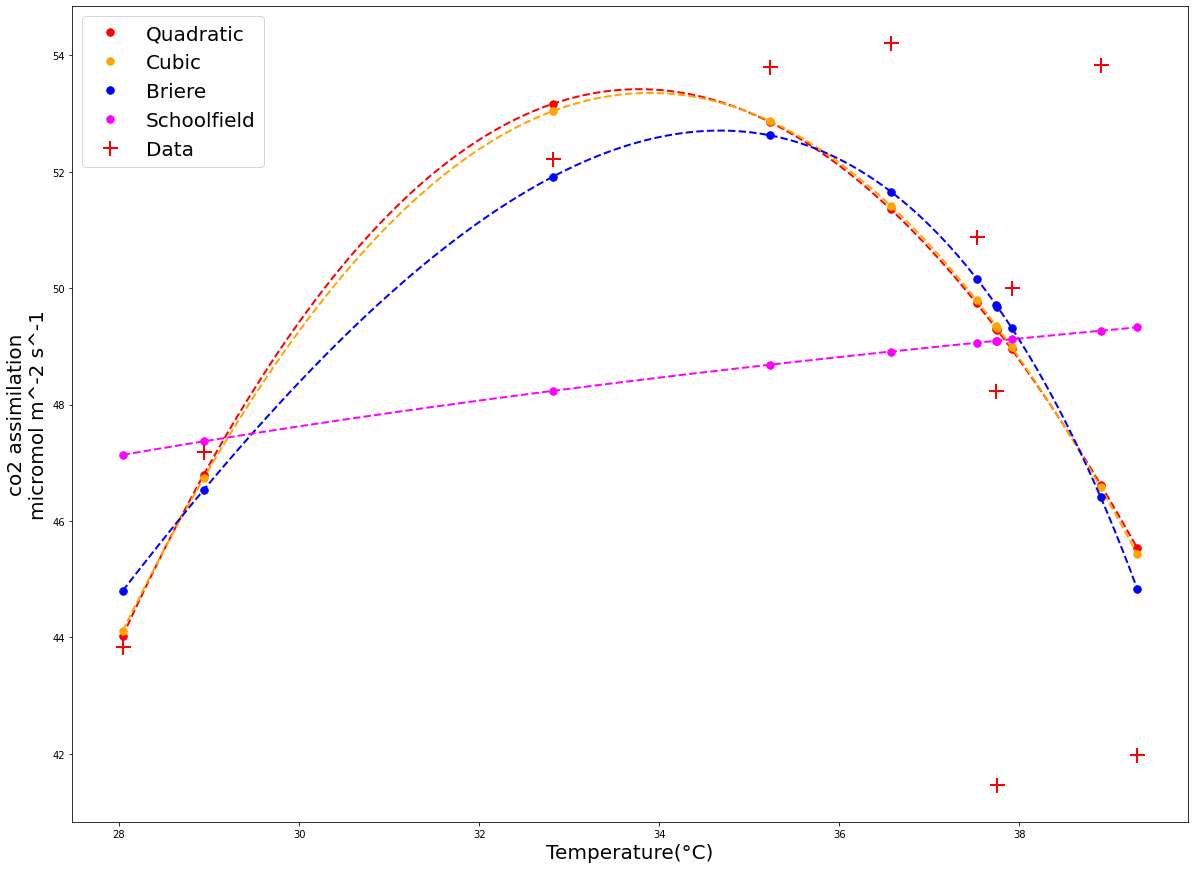

In [37]:
models_visualisation(10, d, params=(fit_cubic, fit_quad, p_bri, p_sch))

In [36]:
def models_visualisation(id, d, params):
    T = np.asarray(d["ConTemp"][d['ID'] == id])  # Temperature in kelvin
    B = np.asarray(d["OriginalTraitValue"][d['ID'] == id])  # Unlogged Trait value
    B_log = np.asarray(d["LoggedOriginalTraitValue"][d["ID"] == id])  # Logged Trait value
    B_name = d.OrignalTraitName[d.ID == id].iloc[0]
    B_unit = d.OriginalTraitUnit[d.ID == id].iloc[0]

    fitting_plot_OLS(
        x=T,
        fit_model=(params[0], params[1]),
        name=("Quadratic", "Cubic"),
        color=("red", "Orange")
    )

    result_model = B + residuals_briere(params[2], T, B)
    plt.plot(T, result_model, '.', markerfacecolor="blue", 
    markeredgecolor="blue", markersize=15, label="Briere")
    # Get a smooth curve by plugging a time vector to the fitted non-linear model
    t_vec = np.linspace(min(T), max(T), 1000)
    N_vec = np.ones(len(t_vec))
    residual_smooth = residuals_briere(p_bri, t_vec, N_vec)
    plt.plot(t_vec, residual_smooth + N_vec, "blue", linestyle='--', linewidth=2)

    result_model = B + residuals_school_original(params[3], T, B)
    plt.plot(T, result_model, '.', markerfacecolor="magenta", 
    markeredgecolor="magenta", markersize=15, label="Schoolfield")
    # Get a smooth curve by plugging a time vector to the fitted non-linear model
    t_vec = np.linspace(min(T), max(T), 1000)
    N_vec = np.ones(len(t_vec))
    residual_smooth = residuals_school_original(p_sch, t_vec, N_vec)
    plt.plot(t_vec, residual_smooth + N_vec, "magenta", linestyle='--', linewidth=2)

    # Plot data points
    plt.plot(T, B, 'r+', markersize=15,
    markeredgewidth=2, label='Data')

    # Plot legend
    plt.legend(fontsize=20)
    plt.xlabel('Temperature(°C)', fontsize=20)
    plt.ylabel('%s\n%s' % (B_name, B_unit), fontsize=20)
    plt.ticklabel_format(style='scientific', scilimits=[0, 3])

In [3]:
def linear_models(id, data, only_return_info = True):
    ''' Fitting three linear model using OLS method '''
    T = np.asarray(data["ConTemp"][data['ID'] == id])  # Temperature in kelvin
    B = np.asarray(data["OriginalTraitValue"][data['ID'] == id])  # Unlogged Trait value

    # Get fitting info of quadratic model
    fit_quad = np.polyfit(T, B, 2)
    resi2 = residual(fit_quad, T, B)
    rss2 = sum(resi2 ** 2)
    tss2 = sum((B - np.mean(B)) ** 2)
    rsq2 = 1 - (rss2/tss2)
    aic2 = get_AIC(resi2, B, fit_quad)
    bic2 = get_BIC(resi2, B, fit_quad)
    aicc2 = aic2 + 2 * 4 * ((4 + 1)/(len(T) - 4 - 1))

    results_all_quad = {
        "id": [id],
        "param1": fit_quad[0],
        "param2": fit_quad[1],
        "param3": fit_quad[2],
        "RSS": rss2,
        "TSS": tss2,
        "Rsq": rsq2,
        "aic": aic2,
        "bic": bic2,
        "aicc": aicc2
    }

    # Get fitting info of cubic model
    fit_cubic = np.polyfit(T, B, 3)
    resi3 = residual(fit_cubic, T, B)
    rss3 = sum(resi3 ** 2)
    tss3 = sum((B - np.mean(B)) ** 2)
    rsq3 = 1 - (rss3/tss3)
    aic3 = get_AIC(resi3, B, fit_cubic)
    bic3 = get_BIC(resi3, B, fit_cubic)
    aicc3 = aic3 + 2 * 4 * ((4 + 1)/(len(T) - 4 - 1))

    results_all_cubic = {
        "id": [id],
        "param1": fit_cubic[0],
        "param2": fit_cubic[1],
        "param3": fit_cubic[2],
        "param4": fit_cubic[3],
        "RSS": rss3,
        "TSS": tss3,
        "Rsq": rsq3,
        "aic": aic3,
        "bic": bic3,
        "aicc": aicc3
    }
    #################################################################################
    if only_return_info == True:
        return pd.DataFrame(results_all_quad), pd.DataFrame(results_all_cubic)
    else:
        return pd.DataFrame(results_all_quad), pd.DataFrame(results_all_cubic), fit_quad, fit_cubic

In [3]:
briere_info = Briere_model(2, d, min_round = 10, max_round=100)

In [4]:
briere_info

,id,B0,T0,Tm,chisqr,RSS,TSS,Rsq,aic,bic,aicc
0,2,2.969876e-08,-3.833861e+06,40.604086,2.595667,2.595667,42.872523,0.939456,18.911414,17.739728,42.911414


# Visualisation

In [28]:
 # Schoolfield model simplified, appropriate for without high termperature data
 # Schoolfield model simplified, appropriate for without high termperature data
def Schoolfield_model(id, data, min_round, max_round):
    """ fitting simplified Schoolfield model with some rounds """
    #Variables
    T = np.asarray(data["ConTemp"][data['ID'] == id])  # Temperature in kelvin
    B = np.asarray(data["OriginalTraitValue"][data['ID'] == id])  # Unlogged Trait value
    B_log = np.asarray(data["LoggedOriginalTraitValue"][data["ID"] == id])  # Logged Trait value
    # Starting values(matters on converge)
    B0 = 0.01
    E = 0.01
    Th = 0.01
    Eh = 0.01
    
    # Add starting values
    p = Parameters()
    p.add("B0", value = B0, min = 0)
    p.add("E", value = E, min = 0)
    p.add("Th", value = Th, min = np.mean(T) + 273.15, max = max(data["ConTemp"]))
    p.add("Eh", value = Eh, min = 0)
    
    # Initiate an empty dictionary for results
    results_all = {
            "id":[id], 
            "B0":[B0],
            "E":[E],
            "Tl":[Th],
            "El": [Eh],
            "chisqr":[np.NAN],
            "RSS": [np.NAN],
            "TSS": [np.NAN],
            "Rsq": [np.NAN],
            "aic":[np.NAN],
            "bic":[np.NAN],
            "aicc":[np.NAN],
            "RSS_log": [np.NAN],
            "TSS_log": [np.NAN],
            "Rsq_log": [np.NAN],
            "aic_log": [np.NAN],
            "bic_log": [np.NAN],
            "aicc_log": [np.NAN]
    }
    
    round = 0
    while round < max_round:
        
        round += 1
        if results_all["aic"] != [np.NaN] and round > min_round:
            break
        
        #Starting values defined for rounds
        #For the first round use set starting values
        if round == 1:
            p = Parameters()
            p.add("B0", value=B0, min=0)
            p.add("E", value=E, min=0)
            p.add("Th", Th, min=250, max=400)
            p.add("Eh", Eh, min=0)
        else:
            p = Parameters()
            p.add("B0", value = np.random.uniform(0,B0*2), min = 0)
            p.add("E", value = np.random.uniform(0,E*2), min = 0)
            p.add("Th", Th, min = 250, max = 400)
            p.add("Eh", value = np.random.uniform(0, Eh*2),min = 0)
            
        #Results for model fitting on logged values
        try:
            output = minimize(residuals_school_log, p, args = (T, B_log))
            rss_log = sum(residuals_school_log(output.params, T, B_log) ** 2)
            tss_log = sum((B_log - np.mean(B_log)) ** 2)
            rsq_log = 1 - (rss_log/tss_log)
            aic_log = get_AIC(residuals_school_log(output.params, T, B_log), B_log, output.params)
            bic_log = get_BIC(residuals_school_log(output.params, T, B_log), B_log, output.params)
            aicc_log = aic_log + 2 * 4 * ((4 + 1)/(len(T) - 4 - 1))
            # Calculate unlogged fitting
            rss = sum(residuals_school_original(output.params, T, B) ** 2)
            tss = sum(B - np.mean(B) ** 2)
            rsq = 1 - (rss / tss)
            aic = get_AIC(residuals_school_original(output.params, T, B), B, output.params)
            bic = get_BIC(residuals_school_original(output.params, T, B), B, output.params)
            aicc = aic + 2 * 4 * ((4 + 1)/(len(T) - 4 - 1))
            # opt_p = None
            
            if aicc < results_all["aicc"] or results_all["aicc"] == [np.NaN]:
                opt_p = output.params
                results_all = {
                    "id": [id],
                    "B0": [output.params["B0"].value],
                    "E": [output.params["E"].value],
                    "Tl": [output.params["Th"].value],
                    "El": [output.params["Eh"].value],
                    "chisqr": [output.chisqr],
                    "RSS": rss,
                    "TSS": tss,
                    "Rsq": rsq,
                    "aic": aic,
                    "bic": bic,
                    "aicc": aicc,
                    "RSS_log": rss_log,
                    "TSS_log": tss_log,
                    "Rsq_log": rsq_log,
                    "aic_log": bic_log,
                    "bic_log": aic_log,
                    "aicc_log": aicc_log
                }
        except ValueError:
            pass
        continue
    
    return(pd.DataFrame(results_all)), opt_p

In [51]:
school_info, best_p = Schoolfield_model(8, d, min_round=50, max_round=100)

In [52]:
school_info

,id,B0,E,Tl,El,chisqr,RSS,TSS,Rsq,aic,bic,aicc,RSS_log,TSS_log,Rsq_log,aic_log,bic_log,aicc_log
0,8,19.794067,9.892531e-12,250.0,0.232074,0.056464,20.312068,-2997.056892,1.006777,40.157206,40.474972,53.490539,0.056464,0.056464,-1.152011e-08,-6.608017,-6.925783,6.40755


In [53]:
best_p

name,value,initial value,min,max,vary
B0,19.7940672,0.013805982441724736,0.00000000,inf,True
E,9.8925e-12,0.00810193285695741,0.00000000,inf,True
Th,250.000000,250,250.000000,400.000000,True
Eh,0.23207360,0.0014957240878971812,0.00000000,inf,True


In [54]:
def school_visualisation(id, data, best_p):
    T = np.asarray(data["ConTemp"][data['ID'] == id])  # Temperature in kelvin
    B = np.asarray(data["OriginalTraitValue"][data['ID'] == id])  # Unlogged Trait value
    B_log = np.asarray(data["LoggedOriginalTraitValue"][data["ID"] == id])  # Logged Trait value
    B_name = d.OrignalTraitName[d.ID == id].iloc[0]
    B_unit = d.OriginalTraitUnit[d.ID == id].iloc[0]


    plt.rcParams['figure.figsize'] = [10, 10]
    result_model = B + residuals_school_original(best_p, T, B)
    plt.plot(T, result_model, '.', markerfacecolor="magenta", 
                markeredgecolor="magenta", markersize=15, label="Schoolfield")
    # Get a smooth curve by plugging a time vector to the fitted non-linear model
    t_vec = np.linspace(min(T), max(T), 1000)
    N_vec = np.ones(len(t_vec))
    residual_smooth = residuals_school_original(best_p, t_vec, N_vec)
    plt.plot(t_vec, residual_smooth + N_vec, "magenta", linestyle='--', linewidth=2)

    # Plot data points
    plt.plot(T, B, 'r+', markersize=15,
                markeredgewidth=2, label='Data')
    
    # Plot legend
    plt.legend(fontsize=20)
    plt.xlabel('Temperature(°C)', fontsize=20)
    plt.ylabel('%s\n%s' % (B_name, B_unit), fontsize=20)
    plt.ticklabel_format(style='scientific', scilimits=[0, 3])
    # plt.savefig("../Results/TPC_fitting%d.pdf" % i)
    # plt.close()
    
    print("-"*80, '\n')

-------------------------------------------------------------------------------- 



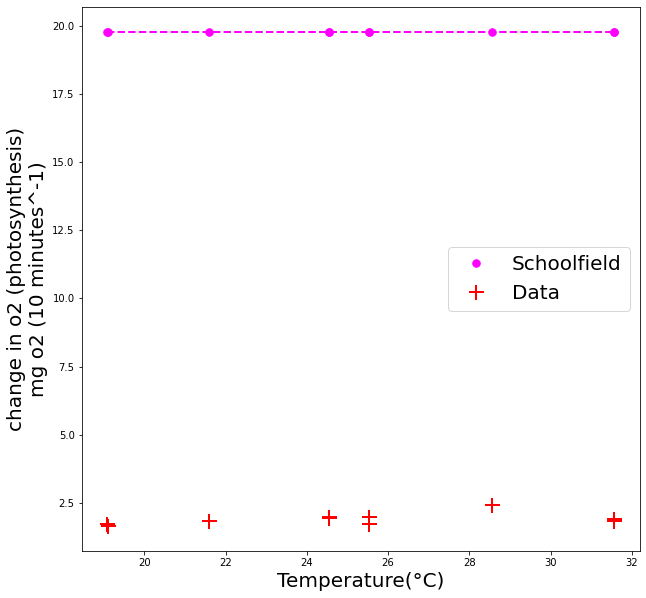

In [55]:
school_visualisation(3, d, best_p)

In [56]:
fit_quad = np.polyfit(sub['ConTemp'], sub['OriginalTraitValue'], 2)

3